In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from IPython import display

In [2]:
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = torch.linspace(-20, 20, train_data_length)
train_data[:, 1] = torch.sin(train_data[:, 0])/train_data[:, 0] - train_data[:, 0]/10
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)]

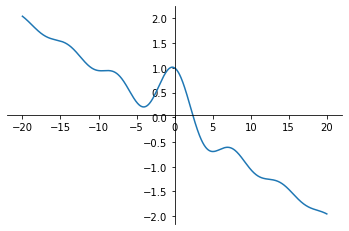

In [3]:
plt.plot(train_data[:, 0], train_data[:, 1])
ax = plt.gca()
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [4]:
batch_size = 128
train_dataloader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, shuffle=True
        )

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(2, 128),
            nn.BatchNorm1d(128, momentum=0.8),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256, momentum=0.8),
            nn.ReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, z):
        data = self.model(z)

        return data

In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

  

    def forward(self, x):

        validity = self.model(x)
        return validity

In [17]:
n_epochs = 200  # количество эпох
lr = 0.0002  # шаг обучения

b1 = 0.5  # гиперпараметр для оптимайзера Adam
b2 = 0.999  # гиперпараметр для оптимайзера Adam

In [18]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(
    generator.parameters(),
    lr=lr, 
    betas=(b1, b2)
)
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), 
    lr=lr, 
    betas=(b1, b2)
)

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

In [19]:
d_loss_history = []
g_loss_history = []

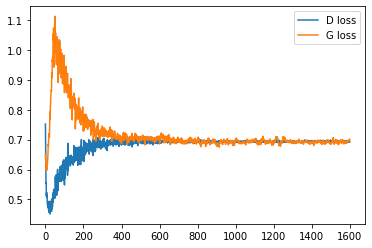

In [20]:
for epoch in range(n_epochs):
    for i, (data, labels) in enumerate(train_dataloader):
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0).to(device)

        real_data = data.type(torch.FloatTensor).to(device)

        # Генерация шума
        z = torch.randn((batch_size, 2)).to(device)
        
        # Генерируем данные Генератором на основе шума
        gen_data = generator(z)
        
######################  Тренировка дискриминатора    ##########################
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_data)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_data)
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

######################  Тренировка генератора    ##########################
        
        # генерация шума
        z = torch.randn((batch_size, 2)).to(device)
        
        # 2Генерируем данные Генератором на основе шума
        gen_data = generator(z)

        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_data)
    
        # Тут сравниваем предсказанные значения Дискриминатора (на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(fake_pred, valid)
        
        # Делаем шаг обучения нашего Генератора
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        
######## Отображение процесса обучения и вывод функций потерь ############

        with torch.no_grad():

            d_loss = d_loss.cpu().detach()
            g_loss = g_loss.cpu().detach()


            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)

plt.plot(np.array(d_loss_history), label='D loss')
plt.plot(np.array(g_loss_history), label='G loss')
plt.legend()
plt.show()        

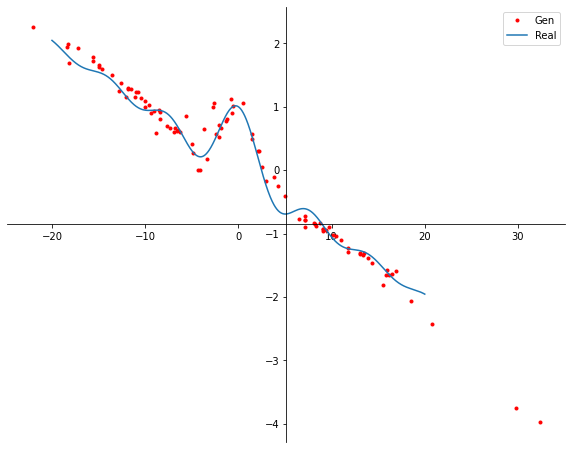

In [21]:
z = torch.randn((100, 2)).to(device)
gen_data = generator(z)
gen_data = gen_data.cpu().detach()

fig, ax = plt.subplots(figsize=(10, 8))  
ax.plot(gen_data[:, 0], gen_data[:, 1], ".", color='r', label="Gen")
ax.plot(train_data[:, 0], train_data[:, 1], label="Real")

ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()

plt.show()